#  Isolating the Poroelastic Response of the Groundwater System in InSAR Data from the Central Valley of California

## Workflow

### Step 1: K-means clustering 
### Step 2: Estimation of loading data 
-  Step 2-1: Linear detrending 
-  Step 2-2: PCA
-  Step 2-2: Polynomial fitting 

### Step 3: Isolation of poroelastic data

In [1]:
import numpy as npy
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.path as mpltPath
from scipy.spatial import cKDTree
import geopandas
import datetime
import matplotlib.dates as mdates
import warnings
warnings.simplefilter("ignore")

C:\Users\sgkan\anaconda3\envs\geo_env\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [48]:
work_dir = "./figures/"

In [2]:
import wget
#downlaod total swe time-series
url = 'https://stacks.stanford.edu/file/druid:kj423qn1813/swe_total.csv'  
wget.download(url, '../data/input_data/', bar=None) 

'../data/input_data//swe_total.csv'

## Load InSAR data and Cluster

In [4]:
ds = xr.open_dataset("../data/input_data/insar_data.nc")
ds_cluster = xr.open_dataset("../data/output_data/insar_cluster.nc")
inds_active = ~(np.isnan(ds.insar_median.values).sum(axis=0)>30).flatten()
x_node = np.r_[ds.lon.values-0.005, ds.lon.values[-1]+0.005]
y_node = np.r_[ds.lat.values-0.005, ds.lat.values[-1]+0.005]

In [5]:
x = ds.lon
y = ds.lat
X, Y = np.meshgrid(x, y)
x_vec = X.flatten()[inds_active]
y_vec = Y.flatten()[inds_active]
x_grid_vec = X.flatten()
y_grid_vec = Y.flatten()
ny, nx = y.size, x.size

In [7]:
cv_line = geopandas.read_file("../data/input_data/cv_line/cv_line.shp")
import json
g = json.loads(cv_line.to_json())
coords = np.array(g['features'][0]['geometry']['coordinates'])
xy_cv = np.vstack(coords[0])[:,:2]
path = mpltPath.Path(xy_cv)
inds_cv = path.contains_points(np.c_[x_grid_vec, y_grid_vec])

In [8]:
x_vec_test = X.flatten()[inds_cv]
y_vec_test = Y.flatten()[inds_cv]
print (inds_cv.sum() - inds_active.sum())

2551


In [9]:
print (inds_active.sum()*0.76/inds_cv.sum())

0.7234354902589443


In [10]:
insar_data_vec = ds.insar_median.values.reshape((ds.time.size, ds.lat.size*ds.lon.size))[:,inds_active]
insar_data_vec[np.isnan(insar_data_vec)] = 0

In [11]:
x_vec_active = X.flatten()[inds_active]
y_vec_active = Y.flatten()[inds_active]

In [12]:
time = ds.time.values
cat_vec = ds_cluster.insar_cluster.values.flatten()[inds_active]
inds_cluster_1 = cat_vec== 0
insar_data_vec_cluster_1 = insar_data_vec[:,inds_cluster_1]
x_vec_cluster_1 = x_vec[inds_cluster_1]
y_vec_cluster_1 = y_vec[inds_cluster_1]
insar_data_vec_cluster_1.shape

(284, 38400)

## Step 2: Estimation of loading data

### 2-1: Linear detrending

In [13]:
import datetime

In [14]:
tmin = pd.to_datetime(time).min()
tmax = pd.to_datetime(time).max()

In [15]:
from discretize import TensorMesh
import SimPEG
time_days = pd.date_range(tmin.to_pydatetime(), tmax.to_pydatetime(), freq="D")
days = np.arange(time_days.size)
days_insar = days[np.in1d(time_days, time)]

In [16]:
time_insar = time_days[np.in1d(time_days, time)]

In [17]:
days_int = np.argwhere((time_days.month == 1) & (time_days.day==1)).flatten()
days_int = np.r_[days_int, 1722]

In [18]:
mesh_td = TensorMesh([np.diff(days_int)])
G = mesh_td.get_interpolation_matrix(loc=days_insar, location_type='nodes').todense()

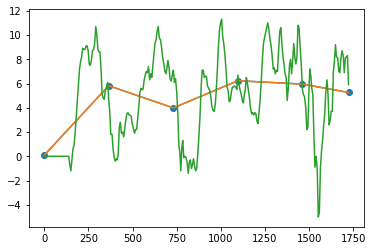

In [19]:
ii = 30
data_tmp = insar_data_vec_cluster_1[:,ii].flatten()
Pinv = np.linalg.pinv(G)
tmp = Pinv.dot(data_tmp)
values = G @ np.array(tmp).flatten()

plt.plot(days_int, np.array(tmp).flatten(), 'o-')
plt.plot(days_insar, np.array(values).flatten())
plt.plot(days_insar, data_tmp.flatten())

In [20]:
df_tmp = pd.DataFrame(data=insar_data_vec_cluster_1)
df_tmp_avg = df_tmp.rolling(60, min_periods=1, center=True).mean()
moving_avg_all = df_tmp_avg.values

In [21]:
values_moving_avg = moving_avg_all[:,ii].flatten()

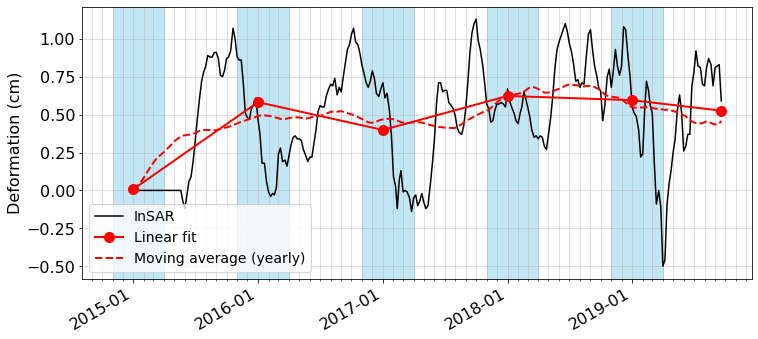

In [22]:
matplotlib.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 5))
# plt.plot(time_insar, np.array(values).flatten())
plt.plot(time_insar, data_tmp.flatten()*0.1, color='k', label="InSAR")
plt.plot(time_days[days_int], np.array(tmp).flatten()*0.1, 'o-', lw=2, color='r', ms=10, label="Linear fit")
plt.plot(time_insar, values_moving_avg*0.1, '--', lw=2, color='r', ms=10, label="Moving average (yearly)")
ax = plt.gca()
ylim = ax.get_ylim()
for year in [2015, 2016, 2017, 2018, 2019]:
    ax.fill_betweenx(ylim, datetime.date(year-1, 11, 1), datetime.date(year, 4, 1), color='skyblue', alpha=0.5)

fmt_half_year = mdates.MonthLocator([1])
ax.xaxis.set_major_locator(fmt_half_year)
# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.format_xdata = mdates.DateFormatter('%Y-%m')
for label in ax.get_xticklabels(which='major'):
    label.set_ha('right')
    label.set_rotation(30)

ax.xaxis.set_major_locator(fmt_half_year)
# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%D')
ax.set_ylim(ylim)
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Deformation (cm)")
ax.legend(fontsize=14)

In [23]:
linear_fit_all = np.array(Pinv.dot(insar_data_vec))

In [24]:
average_rate_all = (np.diff(linear_fit_all, axis=0)/np.diff(days_int)[:, np.newaxis]).sum(axis=0) * 365 / 5

In [25]:
for ii in range(6):
    ind = cat_vec==ii
    tmp = average_rate_all[ind]
    print(ii+1, tmp.mean()*0.1)

1 -0.38835293933870324
2 -3.929301614477148
3 -10.624838483714043
4 -18.74625205676242
5 -1.8825760410251686
6 -10.902028134018035


In [26]:
linear_fit = np.array(Pinv.dot(insar_data_vec_cluster_1))
values = G @ linear_fit

In [27]:
insar_data_vec_cluster_1_detrend_linear = insar_data_vec_cluster_1 - np.array(values)
insar_data_vec_cluster_1_detrend_mavg = insar_data_vec_cluster_1 - moving_avg_all

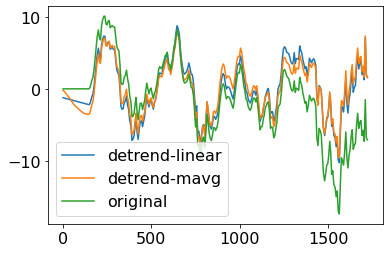

In [28]:
ii = 20
plt.plot(days_insar, insar_data_vec_cluster_1_detrend_linear[:,ii].flatten(), label='detrend-linear')
plt.plot(days_insar, insar_data_vec_cluster_1_detrend_mavg[:,ii].flatten(), label='detrend-mavg')
plt.plot(days_insar, insar_data_vec_cluster_1[:,ii].flatten(), label='original')
plt.legend()

### 2-2: Principal component analysis (PCA)

(-0.15928816151453323, 0.16338300967586036)

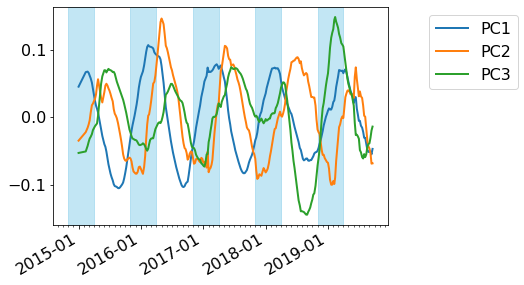

In [34]:
import numpy as np
from sklearn.decomposition import PCA
Data_PCA = insar_data_vec_cluster_1_detrend_linear.T
pca_10 = PCA()
pca_10.mean_ = np.zeros(284)
pca_10.fit(Data_PCA)
n_pcs = 3
data_pca_10 = pca_10.transform(Data_PCA)
for ii in range(n_pcs):
    plt.plot(time_insar, pca_10.components_.T[:,ii], lw=2, alpha=1, label="PC{:d}".format(ii+1))
plt.legend(bbox_to_anchor=(1.1,1))

ax = plt.gca()
ylim = ax.get_ylim()
for year in [2015, 2016, 2017, 2018, 2019]:
    ax.fill_betweenx(ylim, datetime.date(year-1, 11, 1), datetime.date(year, 4, 1), color='skyblue', alpha=0.5)

fmt_half_year = mdates.MonthLocator([1])
ax.xaxis.set_major_locator(fmt_half_year)
# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.format_xdata = mdates.DateFormatter('%Y-%m')
for label in ax.get_xticklabels(which='major'):
    label.set_ha('right')
    label.set_rotation(30)

ax.xaxis.set_major_locator(fmt_half_year)
# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%D')
ax.set_ylim(ylim)
# print(np.cumsum(pca_10.explained_variance_ratio_))

Text(0, 0.5, 'Normalized cumulative variance ratio')

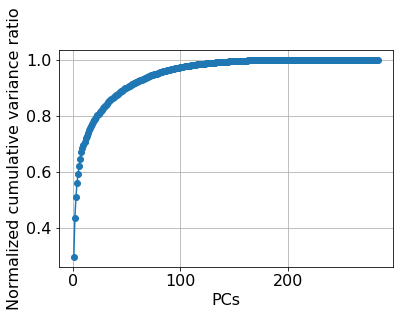

In [35]:
values = np.cumsum(pca_10.explained_variance_ratio_)
plt.plot(np.arange(1, values.size+1),  values, 'o-')
# plt.xticks(np.arange(1, values.size+1))
# plt.ylim(0, 0.8)
plt.grid(True)
plt.xlabel("PCs")
plt.ylabel("Normalized cumulative variance ratio")

In [36]:
df_swe = pd.read_csv("../data/input_data/swe_total.csv")
time_swe = pd.to_datetime(df_swe.values[:,0])
swe = df_swe.values[:,1]

#### Keep only the first PC and apply PCA again

In [37]:
Data_PCA_linear = insar_data_vec_cluster_1_detrend_linear.T
pca_linear = PCA(n_components=1)
pca_linear.fit(Data_PCA_linear)
data_pca_linear = pca_linear.transform(Data_PCA_linear)
Data_PCA_linear_inv = pca_linear.inverse_transform(data_pca_linear)

In [38]:
Data_PCA_mavg = insar_data_vec_cluster_1_detrend_mavg.T
pca_mavg = PCA(n_components=1)
pca_mavg.fit(Data_PCA_mavg)
data_pca_mavg = pca_mavg.transform(Data_PCA_mavg)
Data_PCA_mavg_inv = pca_mavg.inverse_transform(data_pca_mavg)

### Fit the trend with polynomial 

In [39]:
from verde import grid_coordinates, Trend
np.random.seed(0)
inds_rand = np.random.permutation(x_vec_cluster_1.size)
xy = np.c_[x_vec_cluster_1[inds_rand], y_vec_cluster_1[inds_rand]]
values_linear = -data_pca_linear.flatten()[inds_rand]
values_mavg = -data_pca_mavg.flatten()[inds_rand]
values_list = [values_linear, values_mavg]
def divide_k_folds(k, n, i_split, test_size=0.4):
    n_test = int(n * test_size)
    i_start = i_split*n_test
    i_end = i_start + n_test
    inds_test = np.logical_and(np.arange(n)>=i_start, np.arange(n)<i_end)
    return inds_test


k_fold = 5
n =  Data_PCA.shape[0]
train_scores = []
test_scores = []
trends = []
degrees = np.arange(10) + 1
for values in values_list:
    for degree in degrees:
        for i_split in range(k_fold):
            inds_test_split = divide_k_folds(k_fold, n, i_split, test_size=1./k_fold)
            xy_train = xy[~inds_test_split]
            xy_test = xy[inds_test_split]
            coordinates_train = (xy_train[:,0], xy_train[:,1])
            coordinates_test = (xy_test[:,0], xy_test[:,1])
            values_train = values[~inds_test_split]
            values_test = values[inds_test_split]
            trend = Trend(degree=degree).fit(coordinates_train, values_train)
            train_scores.append(trend.score(coordinates_train, values_train))
            test_scores.append(trend.score(coordinates_test, values_test))
            trends.append(trend)

In [40]:
train_scores = np.array(train_scores).reshape((2, len(degrees), k_fold))
test_scores = np.array(test_scores).reshape((2, len(degrees), k_fold))
trends = np.array(trends).reshape((2, len(degrees), k_fold))

In [41]:
inds_degree =  [2, 3, 4, 5, 6]

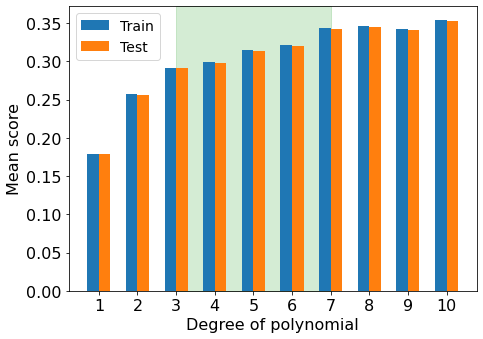

In [42]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
fig = plt.figure(figsize=(7,5))
plt.bar(degrees-0.15, train_scores.mean(axis=2).mean(axis=0), 0.3, label='Train')
plt.bar(degrees+0.15, test_scores.mean(axis=2).mean(axis=0), 0.3, label='Test')
plt.legend(fontsize=14)
ylim = plt.ylim()
xlim = plt.xlim()
plt.fill_between([3, 7], ylim[0]*np.ones(2), y2=ylim[1]*np.ones(2), alpha=0.2, color='C2')
plt.xticks(np.arange(10)+1)
plt.xlabel("Degree of polynomial")
plt.ylabel("Mean score")

plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
fig.savefig("./figures/figure_s6", dpi=200)

In [43]:
trend_vec_tests = []
for jj in range(2):
    for kk in range(k_fold):
        for ii in inds_degree:
            trend = trends[jj, ii,kk]
            trend_vec_tests.append(trend.predict((x_vec_test, y_vec_test)))
trend_vec_tests = np.vstack(trend_vec_tests)        

In [44]:
trend_vec_tests.shape

(50, 53023)

In [45]:
trend_vec_tests_mean = trend_vec_tests.mean(axis=0)

In [46]:
tmp_pca = np.zeros(inds_active.size, dtype=int) * np.nan
tmp_pca[(inds_active) & (ds_cluster.insar_cluster.values.flatten()==0)] = (-data_pca_mavg.flatten() - data_pca_linear.flatten()) * 0.5

tmp_trend = np.zeros(inds_active.size, dtype=int) * np.nan
tmp_trend[inds_cv] = trend_vec_tests_mean

values = [tmp_pca, tmp_trend]
clims = [(-50, 50), None]

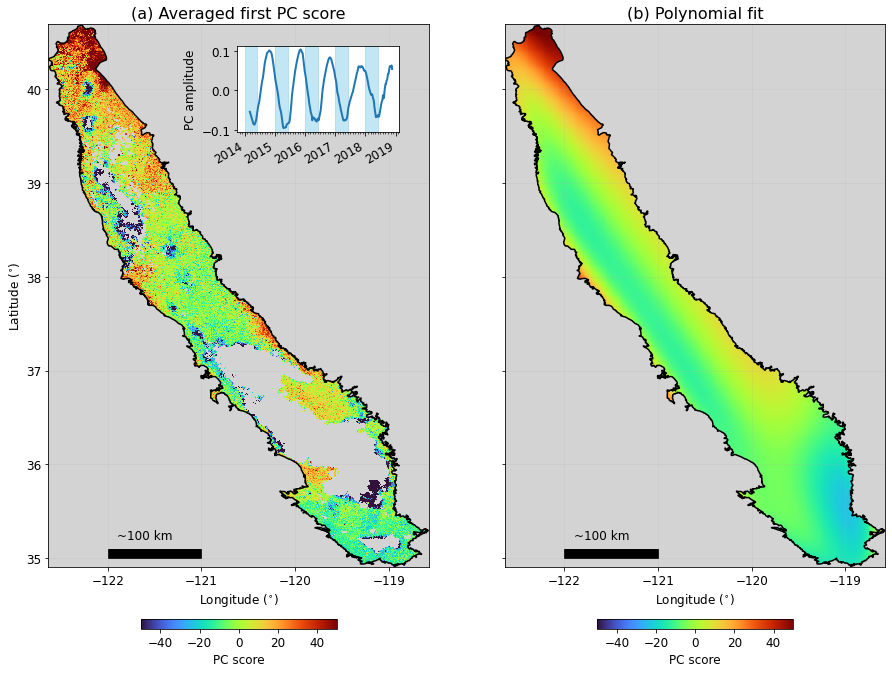

In [51]:
matplotlib.rcParams['font.size'] = 12

fig, axs = plt.subplots(1,2, figsize=(10*1.5, 8*1.5))

for ii, ax in enumerate(axs):
    out = ax.pcolormesh(x_node, y_node, values[ii].reshape((ny, nx)), shading='auto', cmap='turbo', vmin=-50, vmax=50)
    cb = plt.colorbar(out, fraction=0.015, ax=ax, orientation='horizontal', pad=0.08)
    cb.set_label("PC score")
    ax.fill([-122, -121, -121, -122, -122], [35, 35, 35.1, 35.1, 35], color='k')
    ax.text(-121.9, 35.2, "~100 km")
    ax.set_xticks(np.arange(4)-122)
    ax.set_aspect(1)
    ax.grid(True, alpha=0.2)
    
    if ii==0:
        ax.set_ylabel("Latitude ($^{\circ}$)")        
    ax.set_xlabel("Longitude ($^{\circ}$)")    
    cv_line.plot(ax=ax, color='k')
    ax.set_aspect(1)    
    ax.set_facecolor('lightgrey')
    
left, bottom, width, height = [0.3, 0.7, 0.15, 0.1]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(time_insar, (-pca_linear.components_.T[:,0]-pca_mavg.components_.T[:,0])*0.5, lw=2)
# ax2.plot(time_insar, pca.components_.T[:,1], lw=2, alpha=0.3)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ylim = ax2.get_ylim()
for year in [2015, 2016, 2017, 2018, 2019]:
    ax2.fill_betweenx(ylim, datetime.date(year-1, 11, 1), datetime.date(year, 4, 1), color='skyblue', alpha=0.5)
ax2.set_ylim(ylim)

left, bottom, width, height = [0.72, 0.58, 0.15, 0.1]


fmt_half_year = mdates.MonthLocator([11])
ax2.xaxis.set_major_locator(fmt_half_year)
# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax2.xaxis.set_minor_locator(fmt_month)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax2.get_xticklabels(which='major'):
    label.set_ha('right')
    label.set_rotation(30)
ax2.set_ylabel("PC amplitude", fontsize=12)
#     ax.set_xlim(time_insar.min(), time_insar.max())
axs[1].set_yticklabels([])
axs[0].set_title("(a) Averaged first PC score", fontsize=16)
axs[1].set_title("(b) Polynomial fit", fontsize=16)
fig.savefig('./figures/figure_2', dpi=200)

In [52]:
trend_vecs = []
for jj in range(2):
    for kk in range(k_fold):
        for ii in inds_degree:
            trend = trends[jj, ii,kk]
            trend_vecs.append(trend.predict((x_vec, y_vec)))
trend_vecs = np.vstack(trend_vecs)        

In [53]:
n_time = 284
n_pts = 50472
n_sample = trend_vec_tests.shape[0]

In [55]:
n_sample

50

In [56]:
trend_invs = []
trend_invs = np.zeros((n_sample, n_pts, n_time))
for ii in range(n_sample):
    if ii<24:
        trend_invs[ii,:,:] = pca_linear.inverse_transform(-trend_vecs[ii].reshape([-1,1]))
    else:
        trend_invs[ii,:,:] = pca_mavg.inverse_transform(-trend_vecs[ii].reshape([-1,1]))

In [57]:
trend_inv_mean = trend_invs.mean(axis=0)
trend_inv_min = trend_invs.min(axis=0)
trend_inv_max = trend_invs.max(axis=0)

In [58]:
1-np.var(trend_inv_mean-pca_10.mean_) /  np.var(trend_inv_mean)

0.946037699047435

In [59]:
mean_loading = trend_inv_mean[:,:].T.mean(axis=1)
min_loading = trend_inv_min[:,:].T.min(axis=1)
max_loading = trend_inv_max[:,:].T.max(axis=1)

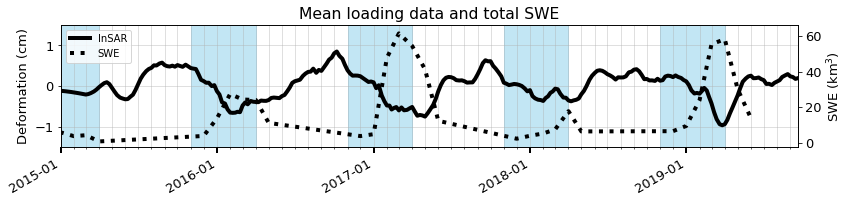

In [60]:
matplotlib.rcParams['font.size'] = 13

fig, ax0 = plt.subplots(1,1, figsize=(12, 3))
ax0.plot(time_insar, mean_loading*0.1, color='k', lw=4, label='InSAR')
# ax0.fill_between(time_insar, min_loading*0.1, y2=max_loading*0.1, color='grey', zorder=999, alpha=0.5, label="$\Delta$InSAR")
ax0.plot(time_insar[0], mean_loading[0], color='k', lw=4, linestyle=':', label='SWE')
ax0.legend(fontsize=10, loc=2)
ax_1 = ax0.twinx()
ax_1.plot(time_swe, swe, color='k', linestyle=':', lw=4)
ylim0 = -15*0.1, 15*0.1
ax0.set_ylim(ylim0)
ax0.set_ylabel("Deformation (cm)")
ax_1.set_ylabel("SWE (km$^3$)")

for year in [2015, 2016, 2017, 2018, 2019]:
    ax0.fill_betweenx(ylim0, datetime.date(year-1, 11, 1), datetime.date(year, 4, 1), color='skyblue', alpha=0.5)

fmt_month = mdates.MonthLocator()
fmt_half_year = mdates.MonthLocator([1])
ax0.xaxis.set_major_locator(fmt_half_year)
ax0.xaxis.set_minor_locator(fmt_month)
# ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax0.set_xlim(time_insar.min(), time_insar.max())
ax0.grid(True, which='both', alpha=0.5)
ax0.set_title("Mean loading data and total SWE")
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax0.tick_params(axis='x', length=6, width=2)

fig.autofmt_xdate() 
plt.tight_layout()
fig.savefig("./figures/figure_4a", dpi=200)

In [61]:
poroelastic_vec = insar_data_vec - trend_inv_mean.T
poroelastic = np.zeros((ds.time.size, ds.lat.size*ds.lon.size), dtype=float) * np.nan
poroelastic[:,inds_active] = poroelastic_vec
poroelastic = poroelastic.reshape((ds.time.size, ds.lat.size, ds.lon.size))

In [64]:
loading_vec = trend_inv_mean.T
loading = np.zeros((ds.time.size, ds.lat.size*ds.lon.size), dtype=float) * np.nan
loading[:,inds_active] = loading_vec
loading = loading.reshape((ds.time.size, ds.lat.size, ds.lon.size))

In [65]:
loading_uncertainty_vec = abs(trend_inv_max - trend_inv_min).T
loading_uncertainty = np.zeros((ds.time.size, ds.lat.size*ds.lon.size), dtype=float) * np.nan
loading_uncertainty[:,inds_active] = loading_uncertainty_vec
loading_uncertainty = loading_uncertainty.reshape((ds.time.size, ds.lat.size, ds.lon.size))

In [81]:
ds['poroelastic'] = (('time', 'lat', 'lon'), poroelastic)
ds['loading'] = (('time', 'lat', 'lon'), loading)
ds['loading_uncertainty'] = (('time', 'lat', 'lon'), loading_uncertainty)
ds.to_netcdf("../data/output_data/insar_loading_poroelastic_data.nc")

In [82]:
relative_diff = np.zeros(insar_data_vec.shape[1])
relative_diff_min = np.zeros(insar_data_vec.shape[1])
relative_diff_max = np.zeros(insar_data_vec.shape[1])
floors = []
for ii in range(6):
    ind = cat_vec==ii
    tmp = insar_data_vec[:,ind]
    ind_tmp = tmp!=0.
    floor_tmp = np.percentile(abs(tmp[ind_tmp]), 4)
    relative_diff[ind] = (abs(insar_data_vec-poroelastic_vec)/(abs(insar_data_vec)+abs(floor_tmp))).sum(axis=0)[ind] / insar_data_vec.shape[0]
    relative_diff_min[ind] = (abs(insar_data_vec-poroelastic_min_vec)/(abs(insar_data_vec)+abs(floor_tmp))).sum(axis=0)[ind] / insar_data_vec.shape[0]
    relative_diff_max[ind] = (abs(insar_data_vec-poroelastic_max_vec)/(abs(insar_data_vec)+abs(floor_tmp))).sum(axis=0)[ind] / insar_data_vec.shape[0]
    
    print(ii+1, floor_tmp, relative_diff[ind].mean(), abs(relative_diff_max[ind].mean()-relative_diff_min[ind].mean()))
    floors.append(floor_tmp)

1 0.5 0.7643218553260983 0.04529151061875436
2 5.3 0.05572438380789608 0.007076155721246029
3 35.0 0.012028212965601914 0.0012468755665964969
4 60.9 0.006255879652024359 0.0007909884317567209
5 2.8 0.10801142782094673 0.014308173246523656
6 25.8 0.012552335378597231 0.001655264307687511


In [83]:
print (relative_diff.mean(), abs(relative_diff_min-relative_diff_max).mean())

0.5937745685093491 0.054503647150613226


In [75]:
import geopandas as gpd
df_50cm = gpd.read_file("../data/output_data/subsidence_5cm/subsidence_5cm.shp")

In [76]:
def foo(ax, i_sounding, data_type='poro', year_min=2012, r=0.01, ylim_insar=None, title=None, legend=None, times_noted=None):
    ax.plot(ds.time, insar_data_vec[:,i_sounding]*0.1, label='InSAR', color='k')
    ax.plot(ds.time, trend_inv_mean.T[:,i_sounding]*0.1, label='Loading', color='k', linestyle='--')
    ax.plot(ds.time, poroelastic_vec[:,i_sounding]*0.1, label='Poroelastic', lw=4, color='crimson')
#     ax.fill_between(ds.time, trend_inv_min.T[:,i_sounding]*0.1, trend_inv_max.T[:,i_sounding]*0.1, color='grey', alpha=0.5)
    ylim = ax.get_ylim()
    for year in [2015, 2016, 2017, 2018, 2019, 2020]:
        ax.fill_betweenx(ylim, datetime.date(year-1, 11, 1), datetime.date(year, 4, 1), color='skyblue', alpha=0.5)
    if times_noted is not None:
        for times in times_noted:
            ax.fill_betweenx(ylim, times[0], times[1], color='crimson', alpha=0.3)
    ax.set_ylim(ylim)
    fmt_half_year = mdates.MonthLocator([1])
    ax.xaxis.set_major_locator(fmt_half_year)
    # Minor ticks every month.
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(fmt_month)
    ax.format_xdata = mdates.DateFormatter('%Y-%m')
    ax.set_xlim(ds.time.min(), datetime.date(2019, 10, 1))
    if legend:
        ax.legend(fontsize=12)
    print(relative_diff[i_sounding])
    return ax, relative_diff[i_sounding]

In [77]:
from scipy.spatial import cKDTree as KDTree
xc1, yc1 = -120.5831753167395, 36.80342202982594
xc2, yc2 = -121.74604660386822, 38.496350972633564
xy_vec = np.c_[x_vec_active, y_vec_active]
tree = KDTree(xy_vec)
_, ind_1 = tree.query(np.r_[xc1, yc1])
_, ind_2 = tree.query(np.r_[xc2, yc2])

In [78]:
times_noted_1 = [
    (datetime.date(2016, 9, 1), datetime.date(2016, 11, 1)),
    (datetime.date(2017, 9, 1), datetime.date(2017, 11, 1)),
    (datetime.date(2019, 3, 1), datetime.date(2019, 5, 1))
]

times_noted_2 = [
    (datetime.date(2016, 1, 1), datetime.date(2016, 3, 1)),
    (datetime.date(2016, 9, 1), datetime.date(2016, 11, 1)),
    (datetime.date(2017, 4, 1), datetime.date(2017, 6, 1)),
    (datetime.date(2019, 2, 1), datetime.date(2019, 5, 1))
]

0.2920442597048588
0.48455896701306067


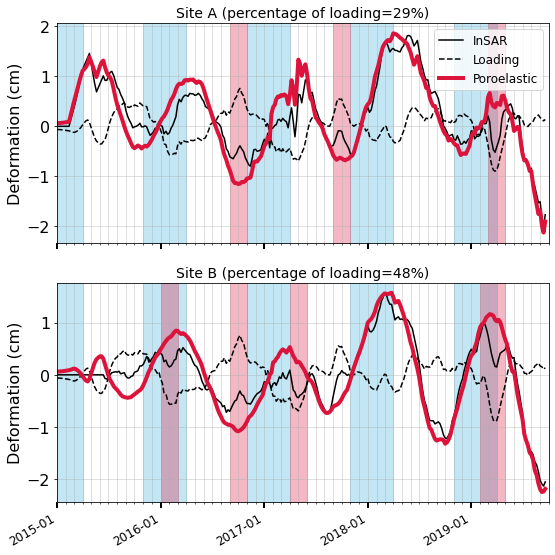

In [79]:
matplotlib.rcParams['font.size'] = 16
fig, axs = plt.subplots(2,1, figsize=(8, 8))
axs_vec = axs.flatten()
ax1, rel_1 = foo(axs_vec[0], ind_1, legend=True, times_noted=times_noted_1)
ax2, rel_2 = foo(axs_vec[1], ind_2, times_noted=times_noted_2)
xcs = [xc1, xc2]
ycs = [yc1, yc2]
rels =[rel_1, rel_2]
titles = ['Site A', 'Site B']

for ii, ax in enumerate(axs_vec):
    ax.set_ylabel("Deformation (cm)")
#     ax.set_title(titles[ii]+" Cluster {:d}, (Lat: {:.2f},Lon:{:.2f})".format(cluster_numbers[ii], xcs[ii], ycs[ii]), fontsize=14)
    ax.set_title(titles[ii]+" (percentage of loading={:.0f}%)".format(rels[ii]*100), fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.grid(True, which='both', alpha=0.5) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    ax.tick_params(axis='x', length=6, width=2)
fig.autofmt_xdate()
plt.tight_layout()
fig.savefig(work_dir+'figure_4c_4d', dpi=200)

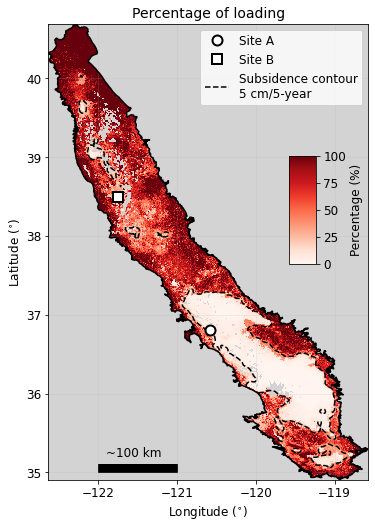

In [80]:
matplotlib.rcParams['font.size'] = 12
x = ds.lon
y = ds.lat
nx = len(x)
ny = len(y)

tmp_rel = np.zeros(inds_active.size, dtype=int) * np.nan
tmp_rel[inds_active] = relative_diff

ii = 30
fig, ax = plt.subplots(1,1, figsize=(5*1.5, 5*1.5))
out = ax.pcolormesh(x_node, y_node, tmp_rel.reshape((ny, nx))*100, shading='auto', cmap='Reds', vmin=0, vmax=100)
ax.contour(x, y, tmp_rel.reshape((ny, nx)), levels=[20])

ax.plot(xc1, yc1, 'o', color='k', markerfacecolor='w', ms=10, markeredgewidth=2, label='Site A')
ax.plot(xc2, yc2, 's', color='k', markerfacecolor='w', ms=10, markeredgewidth=2, label='Site B')

df_50cm.plot(ax=ax, color='k', linestyle='--', label="Subsidence contour\n5 cm/5-year")
ax.legend()


left, bottom, width, height = [0.65, 0.5, 0.05, 0.2]
cax = fig.add_axes([left, bottom, width, height])

cb = plt.colorbar(out, cax=cax)
cb.set_label("Percentage (%)")
ax.fill([-122, -121, -121, -122, -122], [35, 35, 35.1, 35.1, 35], color='k')
ax.text(-121.9, 35.2, "~100 km")
ax.set_xticks(np.arange(4)-122)
ax.set_aspect(1)
ax.grid(True, alpha=0.2)
ax.set_ylabel("Latitude ($^{\circ}$)")
ax.set_xlabel("Longitude ($^{\circ}$)")

ax.set_title("Percentage of loading", fontsize=14)
cv_line.plot(ax=ax, color='k')
ax.set_aspect(1)
ax.set_facecolor('lightgrey')
# ax2.set_facecolor('lightgrey')
plt.tight_layout()
fig.savefig(work_dir+'figure_4b', dpi=200)